## More compex model: ResNet50

In [1]:
!pip install tensorflow
!pip install pydot
!pip install torchaudio
!pip install torcheval
!pip install torchvision
!pip install torchmetrics

  Using cached tensorflow-2.17.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached grpcio-1.66.2-cp311-cp311-manylinux_2_17_x86_64.manylinux20

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torcheval.metrics
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics.classification import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MeanSquaredError

import torch
import torchvision
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

import math

import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, random_split
import torch.nn.functional as F
import torchmetrics
import torcheval
import torcheval.metrics
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics.classification import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MeanSquaredError

  Using cached lightning_utilities-0.11.7-py3-none-any.whl.metadata (5.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 17.1 MB/s eta 0:00:0000:01
Using cached lightning_utilities-0.11.7-py3-none-any.whl (26 kB)


In [57]:
def imshow(img, s=""):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if s and not '\n' in s:
        s = ' '.join(s.split())
        p = s.find(' ', int(len(s) / 2))
        s = s[:p] + "\n" + s[p + 1:]
    plt.text(0, -20, s)
    plt.show()

 Meat Vegetable-Fruit Dessert Dessert Bread Vegetable-Fruit  Soup Dessert Bread Fried food  Meat Seafood  Meat  Soup   Egg  Meat


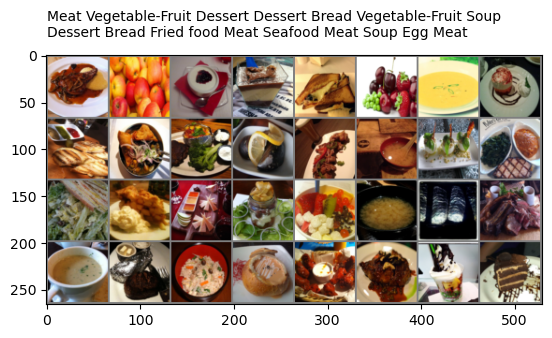

In [58]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dir = '../../Datasets/food/training'
test_dir = '../../Datasets/food/evaluation'

# Load the data
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

dataiter = iter(trainloader)
images, labels = next(dataiter)
s = ' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(16))
print(s)
imshow(torchvision.utils.make_grid(images), s)

In [74]:
## Storing data to print and plot
train_list_accuracy = []
train_list_loss = []

test_list_accuracy = []
test_list_loss = []

list_epoch = []
all_preds = []
all_labels = []

In [75]:
model = resnet50(pretrained=False)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [76]:
# Define the number of epochs
num_epochs = 50

# Train the model
for epoch in range(num_epochs):
    list_epoch.append(epoch+1)
    # Train the model on the training set
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the training loss
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    train_loss /= len(train_dataset)
    train_acc = train_acc.double() / len(train_dataset)

    train_list_loss.append(train_loss)
    train_list_accuracy.append(train_acc.item()) 

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update the test loss and accuracy
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    
    test_loss /= len(test_dataset)
    test_acc = test_acc.double() / len(test_dataset)

    test_list_loss.append(test_loss)
    test_list_accuracy.append(test_acc.item())

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")

Epoch [1/50] Train Loss: 2.3955 Test Loss: 2.2051 Test Acc: 0.3304
Epoch [2/50] Train Loss: 2.0126 Test Loss: 2.4100 Test Acc: 0.3501
Epoch [3/50] Train Loss: 1.9679 Test Loss: 3.0194 Test Acc: 0.2818
Epoch [4/50] Train Loss: 1.9408 Test Loss: 2.7661 Test Acc: 0.3481
Epoch [5/50] Train Loss: 1.8017 Test Loss: 1.7097 Test Acc: 0.4322
Epoch [6/50] Train Loss: 1.7314 Test Loss: 1.7522 Test Acc: 0.4185
Epoch [7/50] Train Loss: 1.6698 Test Loss: 1.8989 Test Acc: 0.4179
Epoch [8/50] Train Loss: 1.6215 Test Loss: 2.1871 Test Acc: 0.3961
Epoch [9/50] Train Loss: 1.6027 Test Loss: 2.0378 Test Acc: 0.4245
Epoch [10/50] Train Loss: 1.5375 Test Loss: 8.9198 Test Acc: 0.4337
Epoch [11/50] Train Loss: 1.4131 Test Loss: 1.5362 Test Acc: 0.4672
Epoch [12/50] Train Loss: 1.2950 Test Loss: 2.1150 Test Acc: 0.4710
Epoch [13/50] Train Loss: 1.2395 Test Loss: 1.9241 Test Acc: 0.4546
Epoch [14/50] Train Loss: 1.1038 Test Loss: 1.6357 Test Acc: 0.4937
Epoch [15/50] Train Loss: 0.8466 Test Loss: 1.7281 Test A

Index  Predicted       Actual         
----------------------------------------
0      Soup            Fried food     
1      Egg             Egg            
2      Soup            Rice           
3      Noodles-Pasta   Noodles-Pasta  
4      Bread           Seafood        
5      Meat            Dessert        
6      Dairy product   Dairy product  
7      Noodles-Pasta   Noodles-Pasta  
8      Seafood         Seafood        
9      Bread           Dessert        
10     Bread           Bread          
11     Fried food      Bread          
12     Rice            Vegetable-Fruit
13     Meat            Meat           
14     Meat            Meat           
15     Meat            Meat           
16     Soup            Soup           
17     Bread           Bread          
18     Meat            Seafood        
19     Noodles-Pasta   Noodles-Pasta  
20     Vegetable-Fruit Soup           
21     Soup            Soup           
22     Seafood         Seafood        
23     Egg             

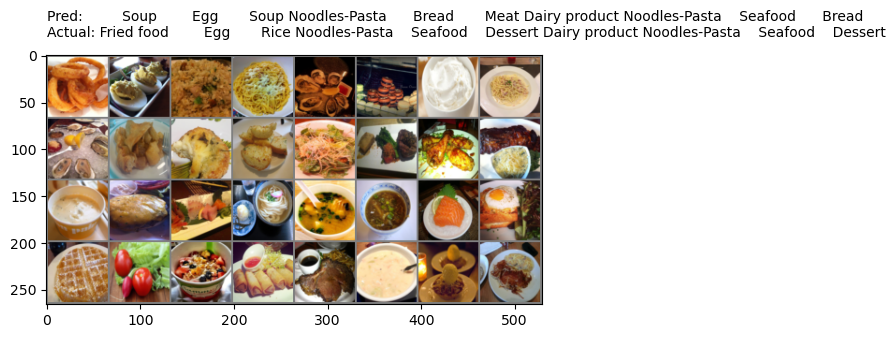

Correct predictions: 19/32 (59.38%)


In [69]:
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu()


correct = torch.sum(predicted == labels).item()
total = len(labels)
accuracy = (correct / total) * 100

print(f"{'Index':<6} {'Predicted':<15} {'Actual':<15}")
print("-" * 40)

for j in range(total):
    print(f"{j:<6} {train_dataset.classes[predicted[j]]:<15} {train_dataset.classes[labels[j]]:<15}")

s1 = "Pred:   " + ' '.join('%10s' % train_dataset.classes[predicted[j]] for j in range(10))
s2 = "Actual: " + ' '.join('%10s' % train_dataset.classes[labels[j]] for j in range(10))

imshow(torchvision.utils.make_grid(images), s1 + "\n" + s2)
print(f"Correct predictions: {correct}/{total} ({accuracy:.2f}%)")


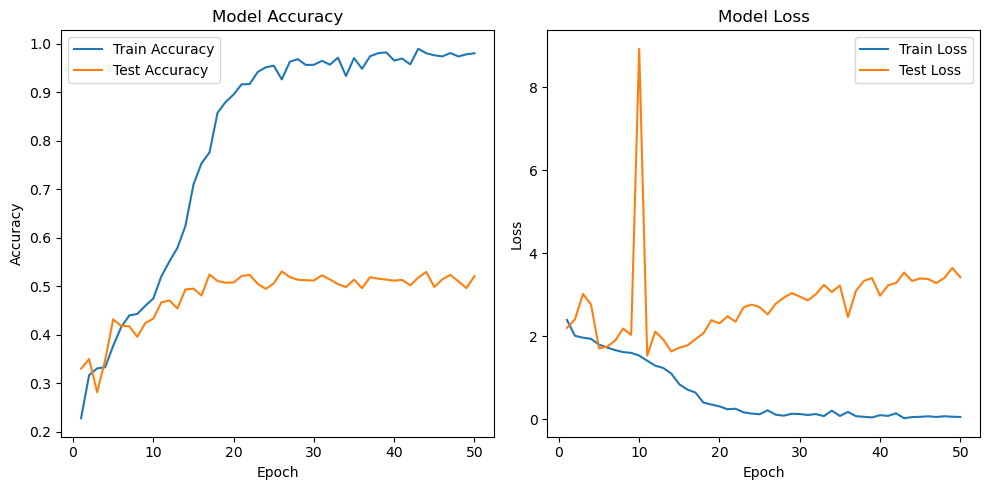

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(list_epoch, train_list_accuracy, label="Train Accuracy")
plt.plot(list_epoch, test_list_accuracy, label="Test Accuracy")
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list_epoch, train_list_loss, label="Train Loss")
plt.plot(list_epoch, test_list_loss, label="Test Loss")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.show()

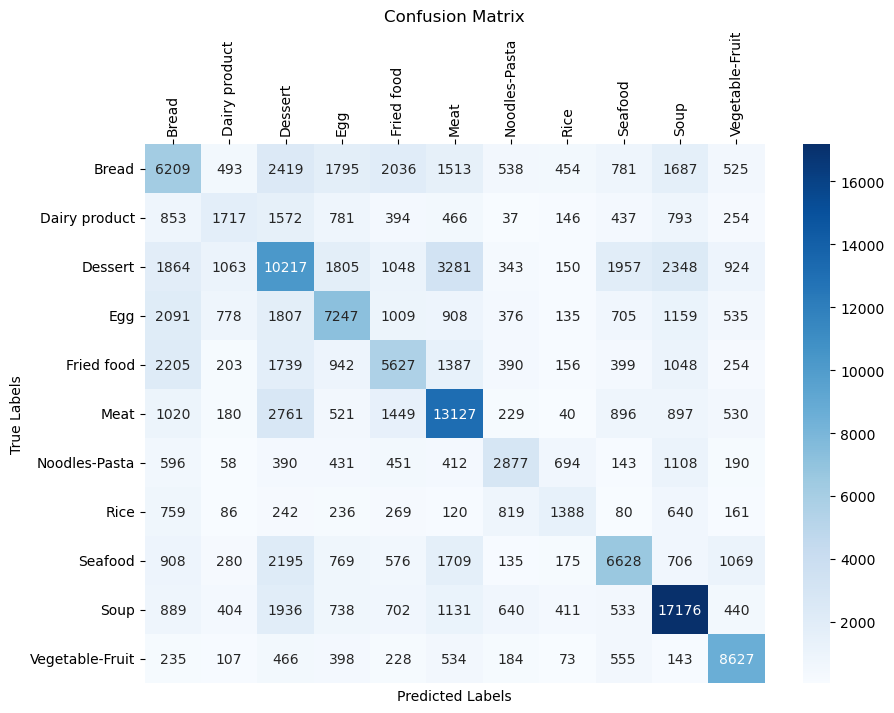

In [78]:
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xticks(rotation=90)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()